# Сборный проект 2

**Описание проекта**

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.
*   EventName — название события;
*   DeviceIDHash — уникальный идентификатор пользователя;
*   EventTimestamp — время события;
*   ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**План проекта**
* Проведем предобработку данных
* Изучим результаты экспериментов
* Проверим пересекаются ли наши выборки для групп А/А/В
* Проверим корректность отбора групп на примере А/А теста
* Проверим статистическую значимость изменений на результатах А/В эксперимента
* Сделаем выводы

In [ ]:
import numpy as np
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from datetime import datetime as dt

In [ ]:
# Настройки
# отображение всех колонок таблиц
pd.set_option('display.max_columns', None)
# ширина колонок при выводе
pd.set_option('display.max_colwidth', 1000)

## Загрузка данных





In [ ]:
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [ ]:
# вывода информации о датафрейме
print(df.info())
print('-' * 50)
display(df.sample(10))
print('-' * 50)
print('Количество дубликатов в датафрейме:', df.duplicated().sum(), '~', \
      round(df.duplicated().sum()/df.shape[0] * 100, 2 ), '%')
print('-' * 50)
print('Наличие пропусков')
print(df.isna().sum())
print('-' * 50)
print('Статистические данные датафрейма')
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
--------------------------------------------------


,EventName,DeviceIDHash,EventTimestamp,ExpId
188009,CartScreenAppear,7984672678297688740,1565084187,247
226404,CartScreenAppear,1069864342136599505,1565178927,248
37947,MainScreenAppear,6101206401239346585,1564693604,247
118675,OffersScreenAppear,2747842226053192632,1564914345,247
227888,CartScreenAppear,5124270451384794915,1565181826,248
200426,MainScreenAppear,2285920690243309957,1565104795,247
93785,OffersScreenAppear,1710404069179158243,1564840300,246
62740,MainScreenAppear,1057369804972986385,1564758977,246
121571,PaymentScreenSuccessful,7225488958072414056,1564918670,247
35623,CartScreenAppear,5180016769043519762,1564687041,247


--------------------------------------------------
Количество дубликатов в датафрейме: 413 ~ 0.17 %
--------------------------------------------------
Наличие пропусков
EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64
--------------------------------------------------
Статистические данные датафрейма


,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


## Предобработка данных

In [ ]:
# приведем названия столбцов к "змеиному" стилю
df = df.rename(columns={'EventName':'event_name',
                        'DeviceIDHash':'device_id',
                        'EventTimestamp':'event_time',
                        'ExpId':'exp_id'})
df.columns

Index(['event_name', 'device_id', 'event_time', 'exp_id'], dtype='object')

In [ ]:
# удаляем дубликаты
df = df.drop_duplicates()

Время в столбце "event_timestamp" упазано в Unix-вормате. Сконвертируем его и  разделим на столбцы даты и времени:

In [ ]:
# приведем тип данных
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')
# добавим столбцы даты и времени
df["date"] = df["event_time"].dt.date
df['date'] = pd.to_datetime(df['date'])
df["time"] = df["event_time"].dt.time

print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   exp_id      243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
 5   time        243713 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 13.0+ MB
None


,event_name,device_id,event_time,exp_id,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42


### Итоги загрузки и предобработки данных
*   в датафрейм 'df' загрузили данные из детасета 'logs_exp.csv'
*   в данных отсутствуют пропуски
*   удалили явные дубликаты: 413 (около 0.17%)
*   скорректирровали названия столбцов
*   привели типы данных
*   разделили значения в столбце 'event_time' на 'date' и 'time' в соответствующих столбцах





## Изучим и проверим данные

In [ ]:
print('Общее количество событий в логе:', df['event_name'].count())
print('-' * 50)
print('Количество уникальных событий:', len(df['event_name'].unique()))
print('-' * 50)
print('Количество по типу событий:')
print(df['event_name'].value_counts())
print('-' * 50)
print('Количество пользователей в логе:', df['device_id'].nunique())
print('-' * 50)
user_event_mean = round((df.groupby('device_id')['event_name'].count()).mean(), 1)
print('В среднем на одного пользователя приходится событий:', user_event_mean)
print('-' * 50)
print('Период проведения эксперимента:')
print('   начало периода -', df['date'].min())
print('   конец периода -', df['date'].max())

Общее количество событий в логе: 243713
--------------------------------------------------
Количество уникальных событий: 5
--------------------------------------------------
Количество по типу событий:
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64
--------------------------------------------------
Количество пользователей в логе: 7551
--------------------------------------------------
В среднем на одного пользователя приходится событий: 32.3
--------------------------------------------------
Период проведения эксперимента:
   начало периода - 2019-07-25 00:00:00
   конец периода - 2019-08-07 00:00:00


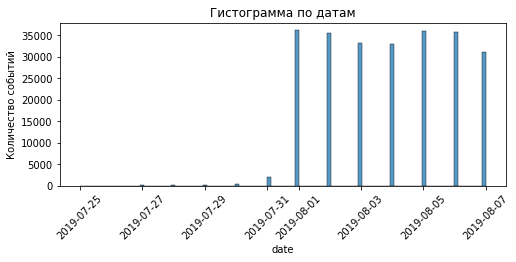

In [ ]:
# построим гистограмму по датам
plt.figure(figsize=(8,3))
sns.histplot(df['date'])
plt.title('Гистограмма по датам')
plt.ylabel('Количество событий')
plt.xticks(rotation = 45)
plt.show()

Гистограмма показывает что данные не за весь период являются полными.
Выберем данные начиная с 2019-08-01.

In [ ]:
df_exp=df.drop(df[df['date'] < '2019-08-01'].index)
print('В результате сокращения выбранного периода отбросили:')
print(df['event_name'].value_counts().sum() - df_exp['event_name'].value_counts().sum(), 'событий ~', \
      round((1 - df_exp['event_name'].value_counts().sum() / df['event_name'].value_counts().sum()) * 100, 2), '%')
print(df['device_id'].nunique() - df_exp['device_id'].nunique(), 'пользователей ~', \
      round((1 - df_exp['device_id'].nunique() / df['device_id'].nunique()) * 100, 2), '%')

В результате сокращения выбранного периода отбросили:
2826 событий ~ 1.16 %
17 пользователей ~ 0.23 %


In [ ]:
# количество пользователей в каждом эксперименте
df_exp.groupby('exp_id').agg({'device_id': ['count', 'nunique']})

device_id        
           count nunique
exp_id                  
246        79302    2484
247        77022    2513
248        84563    2537

### Вывод
*   в результате изучения выделили 5 типов событий:
 *   MainScreenAppear - главный экран
 *   OffersScreenAppear - экран предложения товаров
 *   CartScreenAppear - корзина
 *   PaymentScreenSuccessful - страница успешной оплаты
 *   Tutorial - руководство, обучающая страница.
*   из-за неполных данных скорректировали изучаемы период. В результате корректировки отбросили 2826 событий (~ 1.16%) и 17 пользователей (~ 0.23%)
*   проверили количество уникальных пользователей в каждой группе эксперимента

## Изучим воронку событий

### События логах


In [ ]:
display(df_exp.groupby('event_name')['device_id'].count().sort_values(ascending = False))

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: device_id, dtype: int64

### Посчитаем сколько пользователей совершали каждое из событий и долю пользователей, которые хоть раз совершали событие.


In [ ]:
# группируем логи по событию, определим количество посещений событий и число уникальных пользователей
event_users = df_exp.pivot_table(index=['event_name'], values='device_id', aggfunc={'nunique','count'}).reset_index()
# переименуем столбцы
event_users.columns = ['event', 'events_count', 'users_unique']
# добавим столбец с долей пользователей, которые хоть раз совершали событие
event_users['users_per'] = round(event_users['users_unique'] / df_exp['device_id'].nunique() * 100, 2)
# отсортируем таблицу по доле пользователей
event_users = event_users.sort_values(by = 'users_per', ascending = False).reset_index()
display(event_users)

,index,event,events_count,users_unique,users_per
0,1,MainScreenAppear,117328,7419,98.47
1,2,OffersScreenAppear,46333,4593,60.96
2,0,CartScreenAppear,42303,3734,49.56
3,3,PaymentScreenSuccessful,33918,3539,46.97
4,4,Tutorial,1005,840,11.15


События происходят в следующем порядке:

1.   MainScreenAppear (главный экран)
2.   OffersScreenAppear (экран предложения)
3.   CartScreenAppear (корзина)
4.   PaymentScreenSuccessful (страница успешной оплаты).

Большинство пользователей не воспользовались Tutorial (руководством). Это событие из цепочки событий можно исключить.

In [ ]:
#event_users = event_users[event_users['event'] != 'Tutorial']

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).


In [ ]:
event_users['conv_per'] = round((event_users['users_per'] / event_users['users_per'].shift(1,fill_value = event_users['users_per'].max())) * 100, 2)
display(event_users)

,index,event,events_count,users_unique,users_per,conv_per
0,1,MainScreenAppear,117328,7419,98.47,100.00
1,2,OffersScreenAppear,46333,4593,60.96,61.91
2,0,CartScreenAppear,42303,3734,49.56,81.30
3,3,PaymentScreenSuccessful,33918,3539,46.97,94.77
4,4,Tutorial,1005,840,11.15,23.74


In [ ]:
# в столбце 'conv_per_del' посчитаем разницу в потере пользователей между шагами воронки
event_users['conv_per_del'] = (event_users['conv_per'] - event_users['conv_per'].shift(1,fill_value = event_users['conv_per'].max()))
display(event_users)

,index,event,events_count,users_unique,users_per,conv_per,conv_per_del
0,1,MainScreenAppear,117328,7419,98.47,100.00,0.00
1,2,OffersScreenAppear,46333,4593,60.96,61.91,-38.09
2,0,CartScreenAppear,42303,3734,49.56,81.30,19.39
3,3,PaymentScreenSuccessful,33918,3539,46.97,94.77,13.47
4,4,Tutorial,1005,840,11.15,23.74,-71.03


In [ ]:
print('Доля пользователей доходит от первого события до оплаты:', \
      round(event_users[event_users['event'] == 'PaymentScreenSuccessful']['users_unique'][3] / \
            event_users[event_users['event'] == 'MainScreenAppear']['users_unique'][0] * 100, 2),'%')

Доля пользователей доходит от первого события до оплаты: 47.7 %


### Вывод
*   в результате изучения воронки определили порядок возникновения событий воронки и выпадающее событие 'Tutorial'
*   47.7% проходят путь от главного экрана до успешнолй оплаты товара
*   больше всего пользователей (38%) теряется на шаге перехода от главной страницы до страницы показа товара

## Изучение результатов эксперимента

In [ ]:
# количество пользователей в каждой экспериментальной группе
users_by_groups = df_exp.pivot_table(index=['exp_id'], values='device_id', aggfunc={'nunique'}).reset_index()
users_by_groups.columns = ['group_id', 'unique_users_amount']
users_by_groups

,group_id,unique_users_amount
0,246,2484
1,247,2513
2,248,2537


<div class="alert alert-block alert-info">
    
Добавил проверку ниже.
    
</div>

In [ ]:
# проверка на принадлежность пользователя только к одной группе
uniq_user_group = df_exp.groupby('device_id').agg({'exp_id':'nunique'})
print('Количество пользователей входящие более чем в одну группу:',\
      uniq_user_group[uniq_user_group['exp_id'] > 1]['exp_id'].count())

Количество пользователей входящие более чем в одну группу: 0


### Статистическая значимость между контрольными группами A/A

In [ ]:
# посчитаем число пользователей, совершивших событие в каждой из контрольных групп
events_groups = df_exp.pivot_table(index=['event_name'], values='device_id', columns='exp_id', aggfunc={'nunique'}).reset_index()
# переименуем столбцы
events_groups.columns = ['event_name', '246', '247', '248']
events_groups = events_groups.sort_values(by='248', ascending=False).reset_index()
display(events_groups)

,index,event_name,246,247,248
0,1,MainScreenAppear,2450,2476,2493
1,2,OffersScreenAppear,1542,1520,1531
2,0,CartScreenAppear,1266,1238,1230
3,3,PaymentScreenSuccessful,1200,1158,1181
4,4,Tutorial,278,283,279


Гипотеза:

*   H0: статистически значимой разницы между группами 246 и 247 нет.
*   H1: существует значительная разница между пропорциями в группах 246 и 247.


При проверке гипотез о равенстве среднего будем применять метод Z-тест (z-критерий Фишера), т.к. будем проводить сравнения двух независимых выборок большого размера. Критический уровень статистической значимости примем равным 5%. Создадим функцию с применением поправки Бонферрони:

In [ ]:
def find_stat_value(group1, group2, event, alpha):
    successes1=0
    trials1=0

    for group in group1:
      successes1 += events_groups[events_groups.event_name == event][str(group)].iloc[0]
      trials1 += users_by_groups[users_by_groups.group_id == group]['unique_users_amount'].iloc[0]

    successes2 = events_groups[events_groups.event_name == event][str(group2)].iloc[0]
    trials2 = users_by_groups[users_by_groups.group_id == group2]['unique_users_amount'].iloc[0]

    # пропорция успехов в первой группе:
    p1 = successes1/trials1
    # пропорция успехов во второй группе:
    p2 = successes2/trials2
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    # введём переменную для названия группы
    group_name = ' + '.join(str(x) for x in group1)

    p_value = 1 - distr.cdf(z_value)

    print('p-значение =', round(p_value, 4), 'при alpha =', alpha )

    # применим поправку Бонферрони для множестенных сравнений в кол-ве 4 штук.
    bonferroni_alpha = alpha / 20

    if (p_value < bonferroni_alpha):
        print("Результат:", "Нулевая гипотеза отвергнута: между группами", group_name, "и", group2, "в событии", event, "есть значимая разница")
    else:
        print("Результат:", "Нулевая гипотеза не отвергнута: между группами", group_name, "и", group2, "в событии", event, "нет оснований считать пропорции разными")

    print('-' * 50)

Передадим функции названия групп в цикле перебора списка событий

In [ ]:
for i in events_groups.event_name.unique():
    find_stat_value([246], 247, i, 0.05)

p-значение = 0.3785 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 246 и 247 в событии MainScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.124 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 246 и 247 в событии OffersScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.1144 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 246 и 247 в событии CartScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.0573 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 246 и 247 в событии PaymentScreenSuccessful нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.5312 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 246 и

### Вывод
Гипотеза о равенстве пропорций двух контрольных групп для А/А-эксперимента подтвердилась, статистические критерии не нашли разницу между выборками 246 и 247.

### Статистическая значимость между контрольными и тестовой группами
Проверим гипотезы для группы с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности и с объединённой контрольной группой

Гипотеза:

*  H0: статистически значимой разницы между группами 246 и 248 нет.
*  H1: существует значительная разница между пропорциями в группах 246 и 248.

In [ ]:
for i in events_groups.event_name.unique():
    find_stat_value([246], 248, i, 0.05)

p-значение = 0.1475 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 246 и 248 в событии MainScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.1042 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 246 и 248 в событии OffersScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.0392 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 246 и 248 в событии CartScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.1061 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 246 и 248 в событии PaymentScreenSuccessful нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.4132 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 246 

Гипотеза:

*  H0: статистически значимой разницы между группами 247 и 248 нет.
*  H1: существует значительная разница между пропорциями в группах 247 и 248.

In [ ]:
for i in events_groups.event_name.unique():
    find_stat_value([247], 248, i, 0.05)

p-значение = 0.2294 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 247 и 248 в событии MainScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.4599 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 247 и 248 в событии OffersScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.2893 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 247 и 248 в событии CartScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.6313 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 247 и 248 в событии PaymentScreenSuccessful нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.3827 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 247 

Гипотеза:
*  H0: статистически значимой разницы между объединенными группами 246 + 247 и 248 нет.
*  H1: существует значительная разница между пропорциями в объединенной группе  246+247 и 248.

In [ ]:
for i in events_groups.event_name.unique():
    find_stat_value([246,247], 248, i, 0.05)

p-значение = 0.1471 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 246 + 247 и 248 в событии MainScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.2171 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 246 + 247 и 248 в событии OffersScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.0909 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 246 + 247 и 248 в событии CartScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.3002 при alpha = 0.05
Результат: Нулевая гипотеза не отвергнута: между группами 246 + 247 и 248 в событии PaymentScreenSuccessful нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.3824 при alpha = 0.05
Результат: Нулевая гипотеза не отвергн

### Вывод
Гипотеза о равенстве пропорций 2-х групп для А/В-эксперимента подтвердилась, статистические критерии не нашли разницу между выборками групп 246, 247 и экспериментальной 248.

## Анализ тестовой группы со скорректированным уровнем значимости
Проверим гипотезы c увеличенным значением уровня значимости alpha = 0.1. При анализе результатов теста будем иметь ввиду, что при повышении значения alpha увеличивается вероятность ошибки 1-го рода, принять ошибочное предположение, то есть найти различие между группами, там где его на самом деле нет.

In [ ]:
for i in events_groups.event_name.unique():
    find_stat_value([246], 248, i, 0.1)

p-значение = 0.1475 при alpha = 0.1
Результат: Нулевая гипотеза не отвергнута: между группами 246 и 248 в событии MainScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.1042 при alpha = 0.1
Результат: Нулевая гипотеза не отвергнута: между группами 246 и 248 в событии OffersScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.0392 при alpha = 0.1
Результат: Нулевая гипотеза не отвергнута: между группами 246 и 248 в событии CartScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.1061 при alpha = 0.1
Результат: Нулевая гипотеза не отвергнута: между группами 246 и 248 в событии PaymentScreenSuccessful нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.4132 при alpha = 0.1
Результат: Нулевая гипотеза не отвергнута: между группами 246 и 248

In [ ]:
for i in events_groups.event_name.unique():
    find_stat_value([247], 248, i, 0.1)

p-значение = 0.2294 при alpha = 0.1
Результат: Нулевая гипотеза не отвергнута: между группами 247 и 248 в событии MainScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.4599 при alpha = 0.1
Результат: Нулевая гипотеза не отвергнута: между группами 247 и 248 в событии OffersScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.2893 при alpha = 0.1
Результат: Нулевая гипотеза не отвергнута: между группами 247 и 248 в событии CartScreenAppear нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.6313 при alpha = 0.1
Результат: Нулевая гипотеза не отвергнута: между группами 247 и 248 в событии PaymentScreenSuccessful нет оснований считать пропорции разными
--------------------------------------------------
p-значение = 0.3827 при alpha = 0.1
Результат: Нулевая гипотеза не отвергнута: между группами 247 и 248

Увеличение alpha не изменило результатов проверки гипотез - разница между группами по прежнему не выявлена.

## Общий вывод
*  В результате исследования мы изучили набор логов, за период с 25.07.19 по 07.08.19
* В результате предобработки данных были удалены 413 дубликатов (около 0.17%),
* После изучения данных:
 * Количество пользователей в логе: 7551
 * В среднем на одного пользователя приходится 32 события
 * выявили отсутсвие полных данные в начале периода и скорректировали период: с 01.08.19 по 07.08.19
* Определили количество и последовательность событий:
 * MainScreenAppear - главный экран
 * OffersScreenAppear - экран предложения товаров
 * CartScreenAppear - корзина
 * PaymentScreenSuccessful - страница успешной оплаты
 * и выпадающее событие 'Tutorial'
*  При исследовании воронки событий выяснили, что почти половина первоначальных пользователей проходит весь путь и попадает на страницу успешной оплаты - 47.7% всех пользователей, видящих главную страницу.
* Больше всего пользователей (38%) теряется на шаге перехода от главной страницы до страницы показа товара
* Чтобы ответить на вопрос об эффективности изменений шрифта в приложении, провели 20 проверок статистических гипотез о равенстве пропорций 2-х контрольных и 1-й экспериментальной групп (с уровнем значимости 0.05) и ни одна из проверок не выявила значимой разницы.

* Результаты данного A/A/B-теста показывают, что изменение шрифта во всём приложении на поведение пользователей никак не повлияло.